In [48]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter


In [49]:
data_path = "E:/New_folder/customer churn/customer_data.csv"
df = pd.read_csv(data_path)

In [50]:
df.drop(['RowNumber', 'Surname', 'Gender', 'Geography', 'CustomerId'], axis=1, inplace=True)

In [51]:
# Exploratory Data Analysis (EDA)
def plot_value_counts(column):
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=df)
    plt.title(f"Distribution of {column}")
    plt.show()


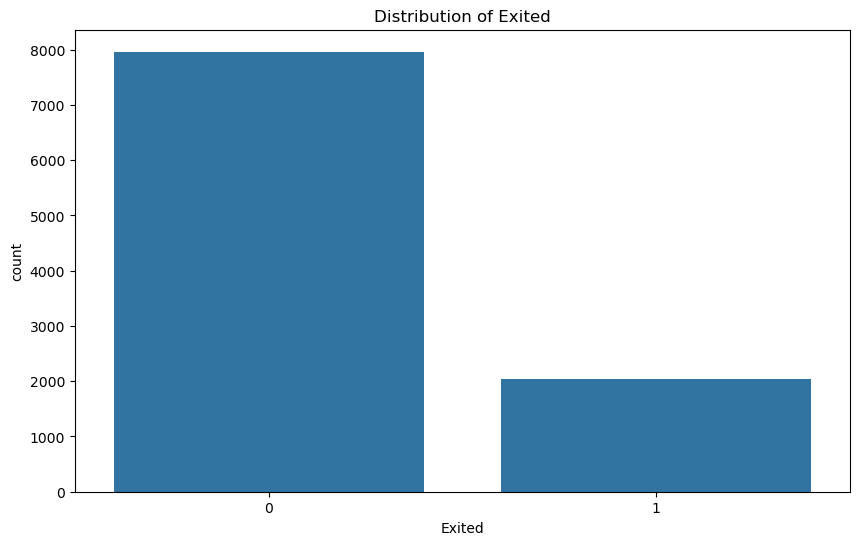

In [52]:
# Plot distribution of 'Exited'
plot_value_counts('Exited')


In [53]:
# Display summary of categorical columns
def display_category_summary(dataframe, columns):
    for col in columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x=dataframe[col], data=dataframe)
        plt.title(f"Count plot for {col}")
        plt.show()
        print(pd.DataFrame({col: dataframe[col].value_counts(), "Ratio": 100 * dataframe[col].value_counts() / len(dataframe)}))
        print("##########################################")

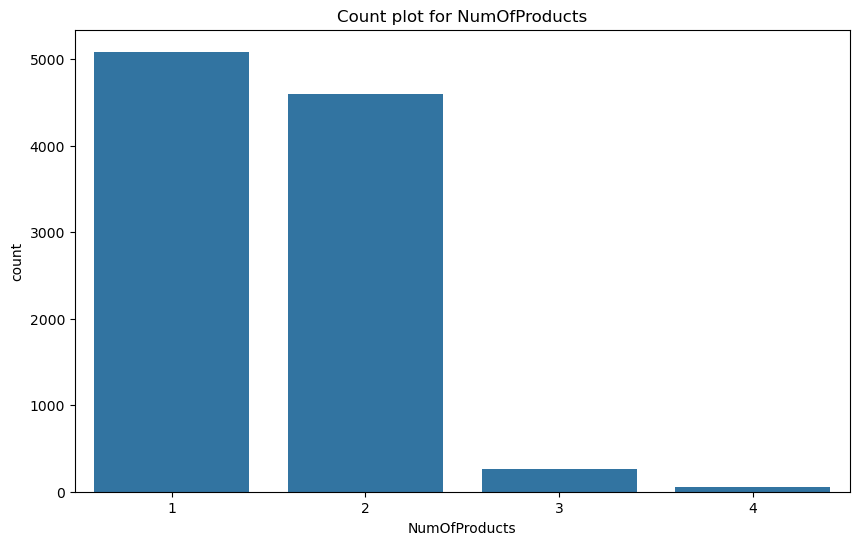

               NumOfProducts  Ratio
NumOfProducts                      
1                       5084  50.84
2                       4590  45.90
3                        266   2.66
4                         60   0.60
##########################################


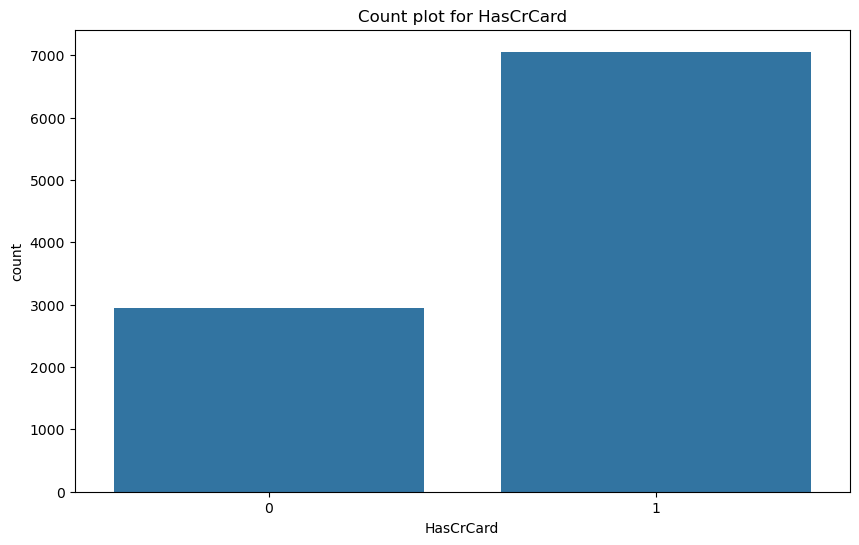

           HasCrCard  Ratio
HasCrCard                  
1               7055  70.55
0               2945  29.45
##########################################


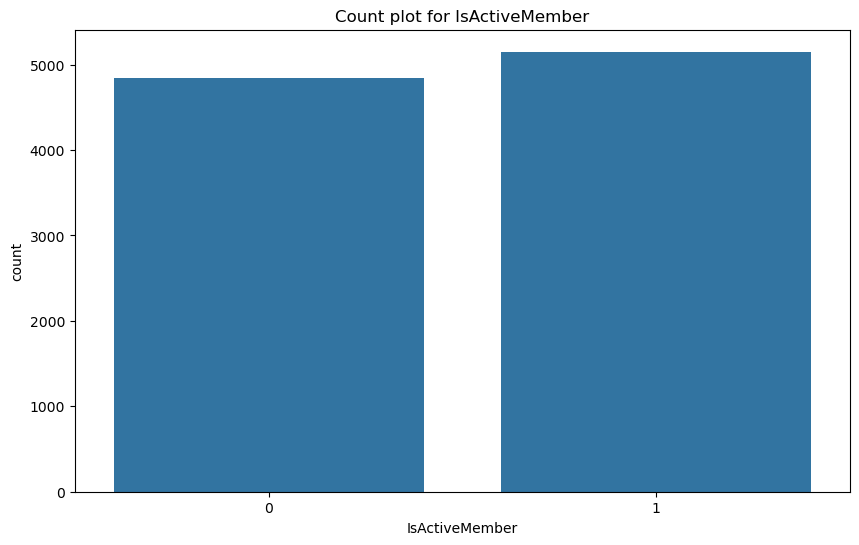

                IsActiveMember  Ratio
IsActiveMember                       
1                         5151  51.51
0                         4849  48.49
##########################################


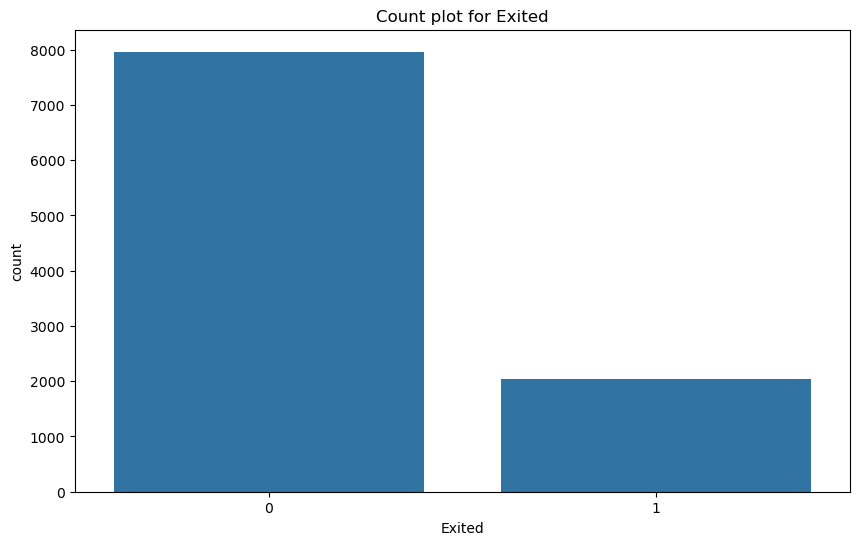

        Exited  Ratio
Exited               
0         7963  79.63
1         2037  20.37
##########################################


In [54]:
category_columns = [col for col in df.columns if df[col].nunique() < 10]
display_category_summary(df, category_columns)


In [55]:
# Compute probabilities for specific conditions
def compute_probabilities(df, feature, target, value):
    prob = round(df[(feature == value) & (target == 1)].shape[0] / df[target == 1].shape[0] * 100, 2)
    return prob

In [56]:
credit_card_prob = compute_probabilities(df, df["HasCrCard"], df["Exited"], 1)
no_credit_card_prob = compute_probabilities(df, df["HasCrCard"], df["Exited"], 0)
active_member_prob = compute_probabilities(df, df["IsActiveMember"], df["Exited"], 1)
inactive_member_prob = compute_probabilities(df, df["IsActiveMember"], df["Exited"], 0)


In [57]:
print(f'Probability of churn with credit card: {credit_card_prob}%')
print(f'Probability of churn without credit card: {no_credit_card_prob}%')
print(f'Probability of churn for active members: {active_member_prob}%')
print(f'Probability of churn for inactive members: {inactive_member_prob}%')

Probability of churn with credit card: 69.91%
Probability of churn without credit card: 30.09%
Probability of churn for active members: 36.08%
Probability of churn for inactive members: 63.92%


In [58]:
corr_matrix = df.corr()
print(corr_matrix)

                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965  0.000842  0.006268       0.012238   
Age                -0.003965  1.000000 -0.009997  0.028308      -0.030680   
Tenure              0.000842 -0.009997  1.000000 -0.012254       0.013444   
Balance             0.006268  0.028308 -0.012254  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680  0.013444 -0.304180       1.000000   
HasCrCard          -0.005458 -0.011721  0.022583 -0.014858       0.003183   
IsActiveMember      0.025651  0.085472 -0.028362 -0.010084       0.009612   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012797       0.014204   
Exited             -0.027094  0.285323 -0.014001  0.118533      -0.047820   

                 HasCrCard  IsActiveMember  EstimatedSalary    Exited  
CreditScore      -0.005458        0.025651        -0.001384 -0.027094  
Age              -0.011721        0.085472        -0.007201  0.285323  
Tenure       

In [59]:
corr_matrix = df.corr()
print(corr_matrix)

                 CreditScore       Age    Tenure   Balance  NumOfProducts  \
CreditScore         1.000000 -0.003965  0.000842  0.006268       0.012238   
Age                -0.003965  1.000000 -0.009997  0.028308      -0.030680   
Tenure              0.000842 -0.009997  1.000000 -0.012254       0.013444   
Balance             0.006268  0.028308 -0.012254  1.000000      -0.304180   
NumOfProducts       0.012238 -0.030680  0.013444 -0.304180       1.000000   
HasCrCard          -0.005458 -0.011721  0.022583 -0.014858       0.003183   
IsActiveMember      0.025651  0.085472 -0.028362 -0.010084       0.009612   
EstimatedSalary    -0.001384 -0.007201  0.007784  0.012797       0.014204   
Exited             -0.027094  0.285323 -0.014001  0.118533      -0.047820   

                 HasCrCard  IsActiveMember  EstimatedSalary    Exited  
CreditScore      -0.005458        0.025651        -0.001384 -0.027094  
Age              -0.011721        0.085472        -0.007201  0.285323  
Tenure       

In [60]:
scaler = MinMaxScaler()
features = df.iloc[:, :-1].values
target = df.iloc[:, -1].values
features_normalized = scaler.fit_transform(features)

In [61]:
# Resampling to handle imbalance
smote = SMOTE(sampling_strategy=1)
features_resampled, target_resampled = smote.fit_resample(features_normalized, target)
print(Counter(target_resampled))


Counter({1: 7963, 0: 7963})


In [62]:
X_train, X_test, y_train, y_test = train_test_split(features_normalized, target, test_size=0.33, random_state=1)
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(features_resampled, target_resampled, test_size=0.33, random_state=1)


In [63]:
# Model training and evaluation functions
def train_model(classifier, x_train, y_train):
    classifier.fit(x_train, y_train)
    return classifier

In [64]:
def evaluate_model(classifier, x_test, y_test):
    y_pred = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Accuracy: {accuracy:.2%}")
    print(f"ROC AUC Score: {roc_auc:.2%}")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()
    print(classification_report(y_test, y_pred))


Logistic Regression (Imbalanced)
Accuracy: 80.79%
ROC AUC Score: 57.05%


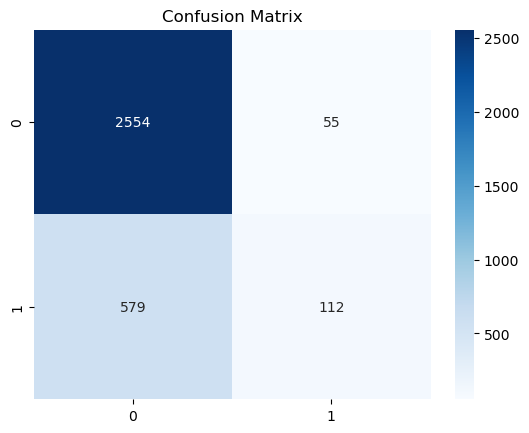

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      2609
           1       0.67      0.16      0.26       691

    accuracy                           0.81      3300
   macro avg       0.74      0.57      0.58      3300
weighted avg       0.78      0.81      0.76      3300



In [65]:
# Logistic Regression
logistic_reg = LogisticRegression(max_iter=1000)
print("Logistic Regression (Imbalanced)")
logistic_reg = train_model(logistic_reg, X_train, y_train)
evaluate_model(logistic_reg, X_test, y_test)


Logistic Regression (Balanced)
Accuracy: 69.98%
ROC AUC Score: 70.02%


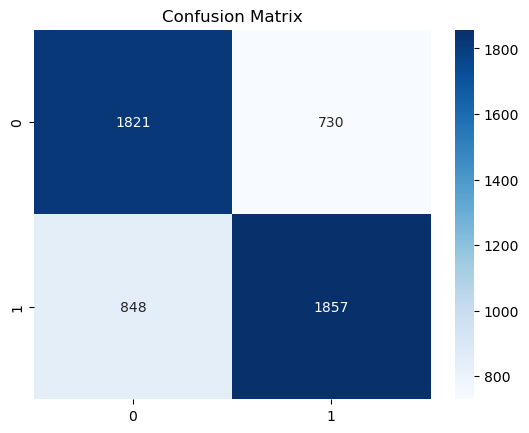

              precision    recall  f1-score   support

           0       0.68      0.71      0.70      2551
           1       0.72      0.69      0.70      2705

    accuracy                           0.70      5256
   macro avg       0.70      0.70      0.70      5256
weighted avg       0.70      0.70      0.70      5256



In [66]:
print("Logistic Regression (Balanced)")
logistic_reg = train_model(logistic_reg, X_train_resampled, y_train_resampled)
evaluate_model(logistic_reg, X_test_resampled, y_test_resampled)

Random Forest Classifier (Imbalanced)
Accuracy: 85.36%
ROC AUC Score: 70.26%


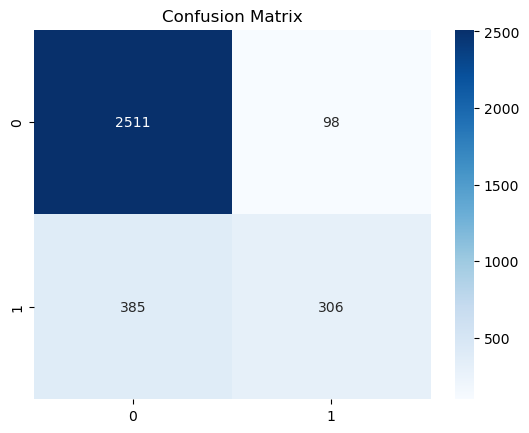

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      2609
           1       0.76      0.44      0.56       691

    accuracy                           0.85      3300
   macro avg       0.81      0.70      0.74      3300
weighted avg       0.84      0.85      0.84      3300



In [67]:
# Random Forest Classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
print("Random Forest Classifier (Imbalanced)")
random_forest = train_model(random_forest, X_train, y_train)
evaluate_model(random_forest, X_test, y_test)


Random Forest Classifier (Balanced)
Accuracy: 88.39%
ROC AUC Score: 88.40%


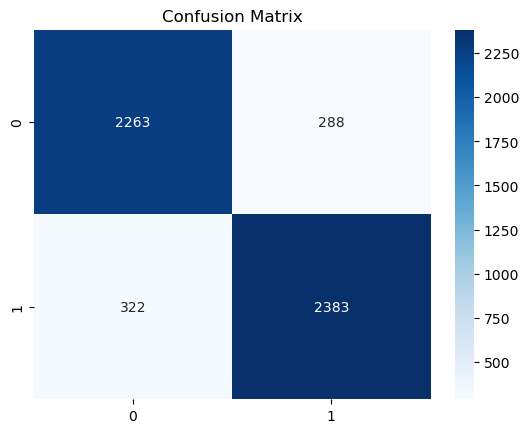

              precision    recall  f1-score   support

           0       0.88      0.89      0.88      2551
           1       0.89      0.88      0.89      2705

    accuracy                           0.88      5256
   macro avg       0.88      0.88      0.88      5256
weighted avg       0.88      0.88      0.88      5256



In [68]:
print("Random Forest Classifier (Balanced)")
random_forest = train_model(random_forest, X_train_resampled, y_train_resampled)
evaluate_model(random_forest, X_test_resampled, y_test_resampled)

Gradient Boosting Classifier (Imbalanced)
Accuracy: 86.00%
ROC AUC Score: 70.93%


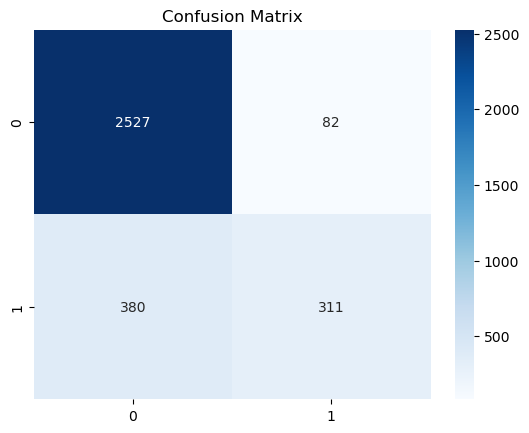

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2609
           1       0.79      0.45      0.57       691

    accuracy                           0.86      3300
   macro avg       0.83      0.71      0.75      3300
weighted avg       0.85      0.86      0.84      3300



In [69]:
# Gradient Boosting Classifier
gradient_boosting = GradientBoostingClassifier(n_estimators=100)
print("Gradient Boosting Classifier (Imbalanced)")
gradient_boosting = train_model(gradient_boosting, X_train, y_train)
evaluate_model(gradient_boosting, X_test, y_test)

Gradient Boosting Classifier (Balanced)
Accuracy: 85.06%
ROC AUC Score: 85.11%


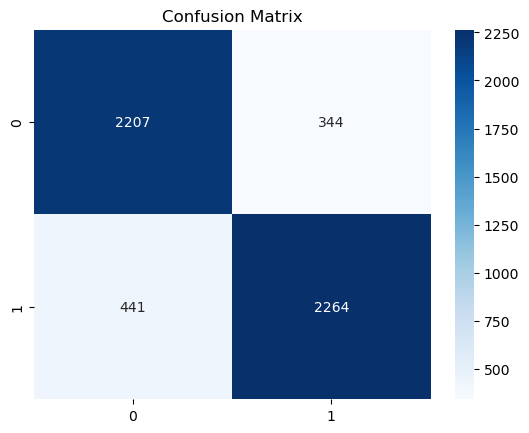

              precision    recall  f1-score   support

           0       0.83      0.87      0.85      2551
           1       0.87      0.84      0.85      2705

    accuracy                           0.85      5256
   macro avg       0.85      0.85      0.85      5256
weighted avg       0.85      0.85      0.85      5256



In [70]:
print("Gradient Boosting Classifier (Balanced)")
gradient_boosting = train_model(gradient_boosting, X_train_resampled, y_train_resampled)
evaluate_model(gradient_boosting, X_test_resampled, y_test_resampled)